# Assignment 9

## Using Dataset 5

In [212]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PyQt5
from random import sample, seed
import seaborn as sns
import itertools
import os
import math
from collections import defaultdict
import sys
from random import sample, seed
from node2vec import Node2Vec #pip install node2vec
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, roc_curve, make_scorer, roc_auc_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [170]:
facebook_edges_filepath = "/Users/michaelmbajwa/Desktop/Semester3/ComplexNetworks/Complex-Networks_exercise-main/Datasets/Group5/Facebook-Ego/686.edges"
twitter_edges_filepath = "/Users/michaelmbajwa/Desktop/Semester3/ComplexNetworks/Complex-Networks_exercise-main/Datasets/Group5/Twitter-Ego/1435461.edges"

In [171]:
# Load the /.edges files

# Facebook is an undirected network
graphFacebook = nx.read_edgelist(facebook_edges_filepath, create_using=nx.Graph())

# Twitter is a directed network
graphTwitter = nx.read_edgelist(twitter_edges_filepath, create_using=nx.DiGraph())

In [172]:
# Basic attributes check
print("Number of nodes = {}, edges = {} in facebook graph.".format(graphFacebook.number_of_nodes(), graphFacebook.number_of_edges()))
print("Number of nodes = {}, edges = {} in Twitter graph.".format(graphTwitter.number_of_nodes(), graphTwitter.number_of_edges()))

Number of nodes = 168, edges = 1656 in facebook graph.
Number of nodes = 129, edges = 8037 in Twitter graph.


### We can predict links based on available features in the graph. Please randomly delete 10% of the edges in the graph, and use any features to train a conventional machine learning algorithm to predict the deleted edges. Please output a report of the prediction accuracy, AUROC, precision and ROC curve.

In [173]:
# Plot graph structure
def plot_graph_structure(G, id):
    plt.rcdefaults()
    plt.rcParams['figure.figsize'] = (15, 8)
    fig, ax = plt.subplots()
    ax.set_facecolor('white')
    ax.set_title("Graph structure {}".format(id), 
                     pad=15, color='#333333',weight='bold')

    ax.set_facecolor('white')
    nx.draw_networkx(G, node_size=10, with_labels=False, arrowstyle='-', arrowsize=1, node_color='red', edge_color='lightgray')
    fig.tight_layout()
    return

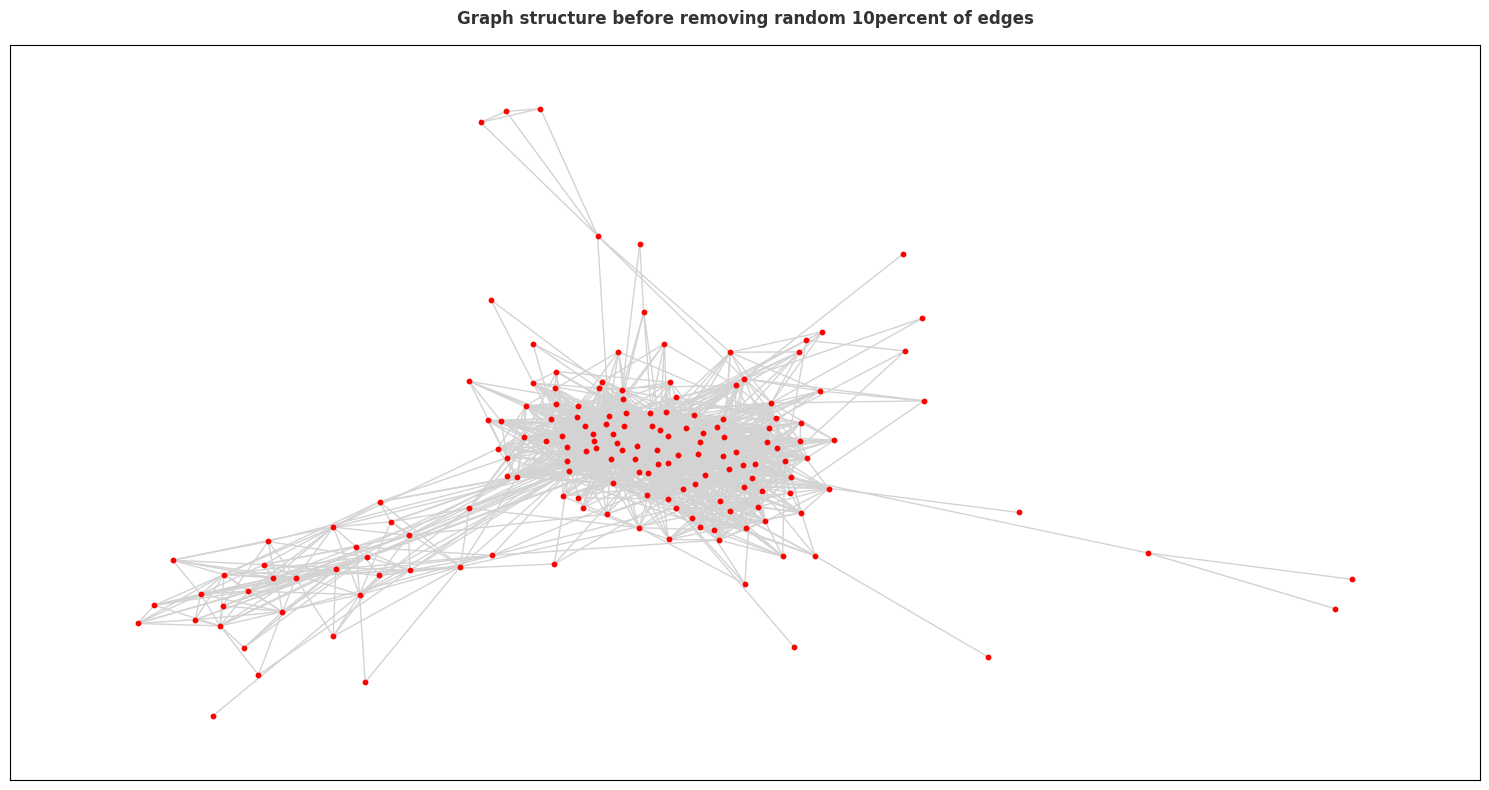

In [174]:
# Let's see the initial graph
%matplotlib inline
plot_graph_structure(graphFacebook, 'before removing random 10percent of edges')

In [175]:
edges_list = [e for e in graphFacebook.edges]
nodes_list = [n for n in graphFacebook.nodes]

### Data preparation

#### 

In [176]:
# Let's get all the unconnected pairs of the facebook graph
unconnected_pairs = []
for node_i in nodes_list:
    for node_j in nodes_list:
        if node_i != node_j:
            node_pairs = (node_i , node_j)
            node_pairs_ = (node_j, node_i)
            if node_pairs not in edges_list and node_pairs_ not in edges_list:
                unconnected_pairs.append(node_pairs)

print("We have {} unconnected node pairs.".format(len(unconnected_pairs)))

We have 24744 unconnected node pairs.


In [177]:
# Now we will remove 10% of the edges from the facebook network
print("Number of connected components:", nx.number_connected_components(graphFacebook))

# from the above print statement, we can see that the facebook network has only one connected component.
# So while removing edges, I will make sure I remove only edges that do not split the graph i.e. nx.number_connected_components(graphFacebook) remains = 1

edges_remove = None # variable to store best edges that we will remove

no_edges = graphFacebook.number_of_edges()
no_edges_remove = round(0.1 * no_edges)
print("{} edges to be removed.".format(no_edges_remove))

for seed_value in range(12, 1222):
    seed(seed_value) # declare seed
    graphFacebook_temp = nx.read_edgelist(facebook_edges_filepath, create_using=nx.Graph())
    print("Number of edges before removing 10%", graphFacebook_temp.number_of_edges())
    edges_list_temp = [e for e in graphFacebook_temp.edges]
    edges_remove_temp = sample(edges_list_temp, no_edges_remove)
    for edge in edges_remove_temp:
        graphFacebook_temp.remove_edge(*edge)
    
    if nx.number_connected_components(graphFacebook_temp) == 1:
        # we will end the program here
        print("We have found an appropraite sample of edges to remove.")
        print("The seed is {}".format(seed_value))
        print("Number of edges after removing 10%", graphFacebook_temp.number_of_edges())
        edges_remove = edges_remove_temp
        break

Number of connected components: 1
166 edges to be removed.
Number of edges before removing 10% 1656
We have found an appropraite sample of edges to remove.
The seed is 12
Number of edges after removing 10% 1490


### Create Train and Test data

#### Train data will contain all the node pairs that form an edge in the new facebook graph we got by deleting 10% of nodes (Target variable will be 1). It will contain some node pairs that do not form an edge (Target variable will be 0).

#### Test data will contain all the node pairs that form an edge that we deleted. It would also contain node pairs that do not form an edge.

Basic attributes check before removing edges:
Number of nodes = 168, edges = 1656 in facebook2 graph.


Basic attributes check after removing edges:
Number of nodes = 168, edges = 1490 in facebook2 graph.


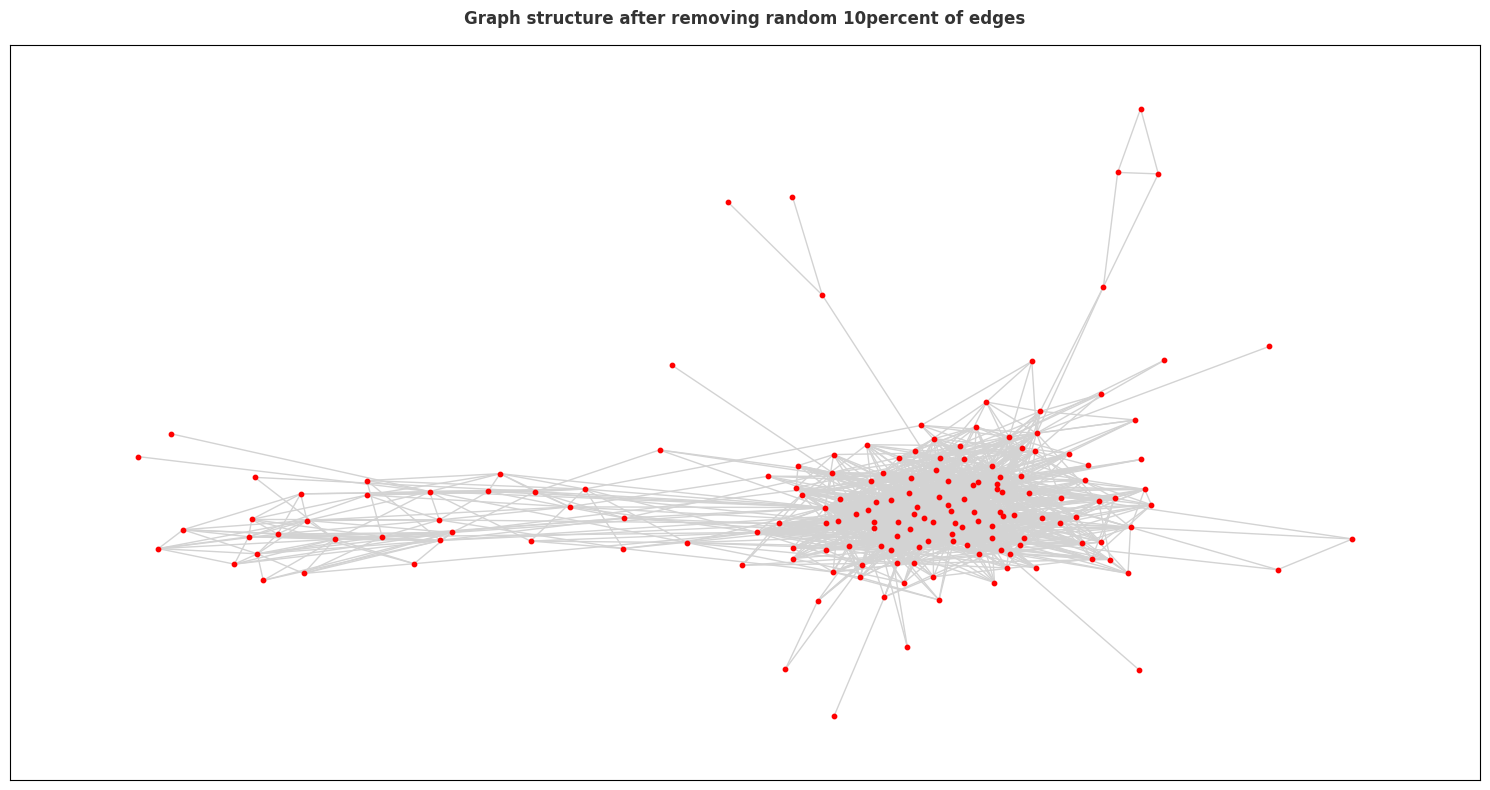

In [178]:
graphFacebook2 = nx.read_edgelist(facebook_edges_filepath, create_using=nx.Graph())

print("Basic attributes check before removing edges:")
print("Number of nodes = {}, edges = {} in facebook2 graph.".format(graphFacebook2.number_of_nodes(), graphFacebook2.number_of_edges()))
print('\n')

# remove 10% of edgbes
for edge in edges_remove:
    graphFacebook2.remove_edge(*edge)

print("Basic attributes check after removing edges:")
print("Number of nodes = {}, edges = {} in facebook2 graph.".format(graphFacebook2.number_of_nodes(), graphFacebook2.number_of_edges()))

# We can visualize the graph
%matplotlib inline
plot_graph_structure(graphFacebook2, 'after removing random 10percent of edges')

In [179]:
# randomly sample the unconnected pairs to be used for the train and test dataframes
train_uc, test_uc = train_test_split(unconnected_pairs, test_size=0.3, random_state=42)

In [180]:
# Construct Train dataframe
edges_list_gf2 = [e for e in graphFacebook2.edges]
train_df = pd.DataFrame(edges_list_gf2, columns=['node_1', 'node_2'])
train_df['link'] = 1
print(train_df.shape)
train_uc_df = pd.DataFrame(train_uc, columns=['node_1', 'node_2'])
train_uc_df['link'] = 0
print(train_uc_df.shape)

train_df = pd.concat([train_df, train_uc_df], axis=0, ignore_index=True)
print(train_df.shape)

# reshuffle the dataframe
train_df = train_df.sample(frac=1).reset_index(drop=True)

(1490, 3)
(17320, 3)
(18810, 3)


In [181]:
# construct Test dataframe
test_df = pd.DataFrame(edges_remove, columns=['node_1', 'node_2'])
test_df['link'] = 1
print(test_df.shape)
test_uc_df = pd.DataFrame(test_uc, columns=['node_1', 'node_2'])
test_uc_df['link'] = 0
print(test_uc_df.shape)

test_df = pd.concat([test_df, test_uc_df], axis=0, ignore_index=True)
print(test_df.shape)

# reshuffle the dataframe
test_df = test_df.sample(frac=1).reset_index(drop=True)

(166, 3)
(7424, 3)
(7590, 3)


## Feature Extraction

#### To extract features from the graph, I will be using the node2vec algorithm:https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf

### Let's use the facebook graph that has 10% of it edges removed to extract features

In [182]:
# train the node2vec on our graph
# Generate walks
node2vec = Node2Vec(graphFacebook2, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
model = node2vec.fit(window=7, min_count=1)
# Now we have extracted the features for each node

Computing transition probabilities:   0%|          | 0/168 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 59.42it/s]


In [183]:
# Next, we will apply the trained node2vec model on each and every node pair in the dataframe ‘data’. 
# To compute the features of an edge, we will add up the features of each node in that pair:

x_train = [(model.wv.get_vector(node_i)+ model.wv.get_vector(node_j)) for node_i,node_j in zip(train_df['node_1'], train_df['node_2'])]
x_test = [(model.wv.get_vector(node_i)+ model.wv.get_vector(node_j)) for node_i,node_j in zip(test_df['node_1'], test_df['node_2'])]

### Train the model

train_data = lgbm.Dataset(x_train, np.ravel(train_df['link']))
test_data = lgbm.Dataset(x_test, np.ravel(test_df['link']))

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

In [204]:
model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)
model.fit(x_train, np.ravel(train_df['link']))

RandomForestClassifier(max_depth=100, random_state=42)

In [209]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(x_train, np.ravel(train_df['link']))

LogisticRegression(class_weight='balanced', max_iter=1000)

In [210]:
# predict
results = model.predict(x_test)
acc_score = accuracy_score(test_df['link'], results)

rocAucScore = roc_auc_score(test_df['link'], results)
precision_score = precision_score(test_df['link'], results)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_df['link'], results)
auc_metrics_rf = auc(fpr_rf, tpr_rf)

# print results
print("AUC is:", auc_metrics_rf)
print("Accuracy score for RandomForestClassifier is:", acc_score)
print("roc_auc_score is: ", rocAucScore)
print("Precision score is:", precision_score)

AUC is: 0.7349381361653511
Accuracy score for RandomForestClassifier is: 0.7176548089591568
roc_auc_score is:  0.7349381361653511
Precision score is: 0.05612932195779075


Confusion matrix, without normalization
[[5322 2102]
 [  41  125]]
Normalized confusion matrix
[[0.71686422 0.28313578]
 [0.24698795 0.75301205]]


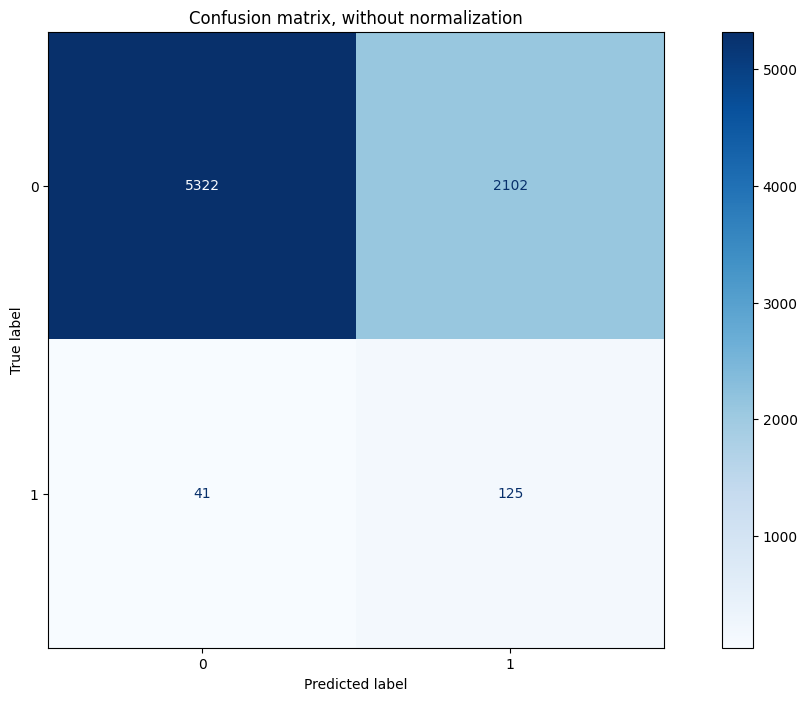

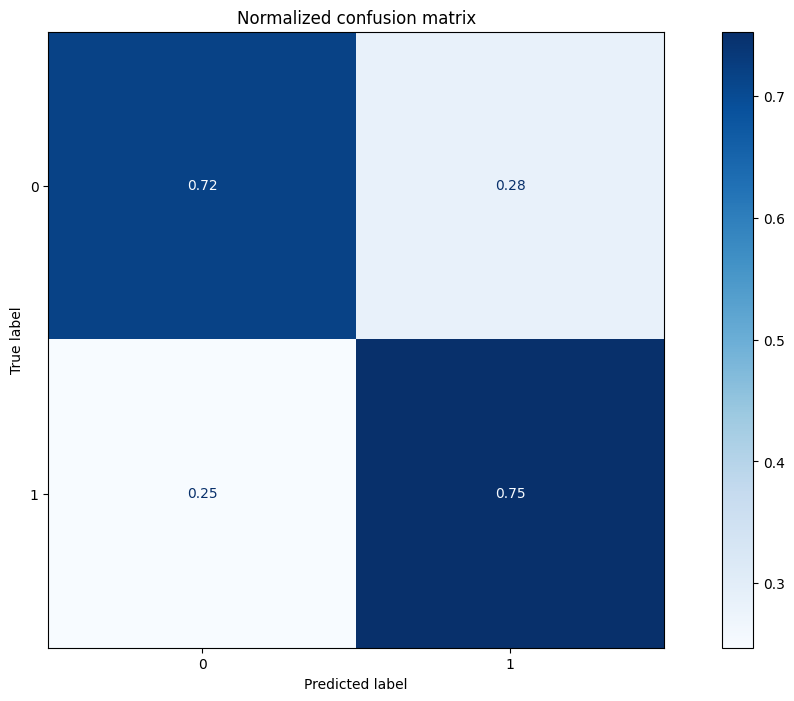

In [211]:
# Let's view the confusion matrix
confusion_matrix(test_df['link'], results)

#Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        x_test,
        test_df['link'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()